# Markov Chain Model

* Team : Data Crew

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from collections import defaultdict

sns.set_style('whitegrid')

## Data

In [22]:
data = pd.read_csv('../../1. Data/smaller_sample.csv')
event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

df = fingerhut_data_cleaner(data, event_defs)

idxs = list(df[df['event_name'] == 'promotion_created'].index)
# DROP THE INDEX OF THIS QUERY IN THE DATASET
df.drop(idxs, inplace=True)
df.reset_index(drop=True, inplace=True)

## Sequences (Obtaining sequences)

### Obtaining the sequences with the correct states

* Function for the sequences and the states

In [23]:
result_sequences = split_sequences(df)

* Assigning the probabilities for each state

In [24]:
result_sequences[0:3]

[[2, 19, 3, 19, 19, 3, 19, 19, 19, 3, 19, 12],
 [15],
 [19,
  19,
  19,
  19,
  19,
  19,
  3,
  19,
  19,
  19,
  3,
  12,
  4,
  11,
  4,
  4,
  4,
  11,
  4,
  4,
  5,
  4,
  4,
  11,
  5,
  5,
  5,
  6,
  4,
  4,
  5,
  4,
  4,
  11,
  5,
  4,
  11,
  5,
  4,
  5,
  6,
  7,
  8,
  29,
  4,
  4,
  4,
  11,
  4,
  4,
  11,
  5,
  27,
  5,
  4,
  5,
  4,
  5,
  5,
  6,
  6,
  28]]

### Distribution of the length of the sequences

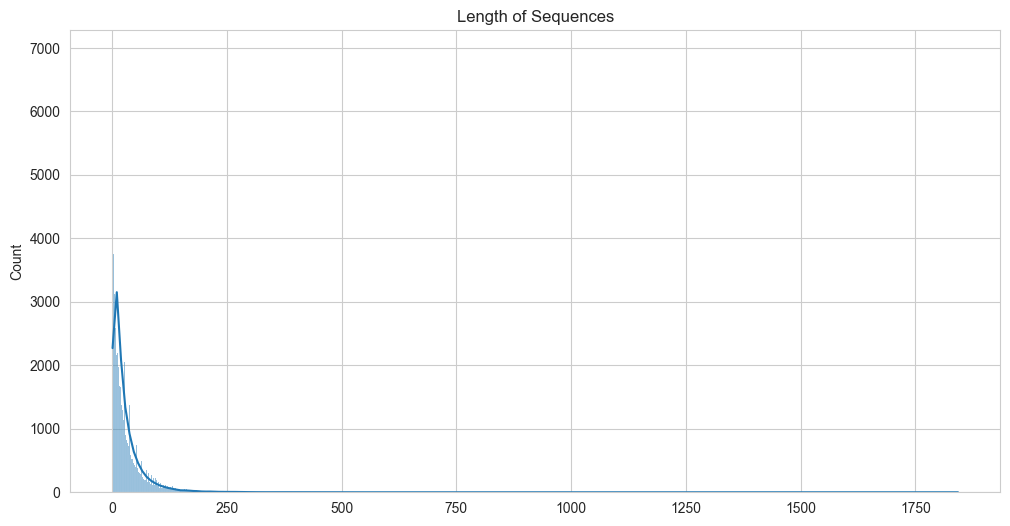

In [25]:
lengths = []
for seq in result_sequences:
    lengths.append(len(seq))
    
plt.figure(figsize=(12, 6))
sns.histplot(lengths, kde=True)
plt.title('Length of Sequences')
plt.show()

## Models proposed for probabilities/prediction of the events

* Markov Chain (probs) - Dan & Axel
* Hidden Markov Model (probs) - Dan & Axel
* LSTM for prediction on the next state - TARO

### Markov Chain for probabilities

#### Transition Matrix

* Defining the transition matrix

In [26]:
# This is going to be our transition matrix
# It will be a dictionary of dictionaries
probs = {}

# Estimation of the transition probabilities
for seq in result_sequences:
    for i in range(len(seq) - 1):
        current_state = seq[i]
        next_state = seq[i + 1]
        
        if current_state == 1:
            print('warning at', i)

        if current_state not in probs:
            # Default dict to add withour checking if the key exists
            probs[current_state] = defaultdict(float)

        probs[current_state][next_state] += 1

probs

{2: defaultdict(float,
             {19: 7741.0,
              12: 20960.0,
              4: 6708.0,
              5: 1647.0,
              3: 459.0,
              27: 265.0,
              22: 3808.0,
              23: 20.0,
              6: 796.0,
              21: 1138.0,
              24: 1565.0,
              29: 468.0,
              13: 425.0,
              2: 244.0,
              8: 39.0,
              11: 328.0,
              18: 61.0,
              15: 16.0,
              26: 11.0,
              28: 6.0,
              10: 1.0,
              7: 12.0}),
 19: defaultdict(float,
             {3: 52971.0,
              19: 210885.0,
              12: 15636.0,
              4: 13907.0,
              5: 3120.0,
              11: 653.0,
              6: 1202.0,
              2: 2372.0,
              24: 1444.0,
              7: 52.0,
              21: 1921.0,
              29: 339.0,
              13: 459.0,
              15: 37.0,
              22: 110.0,
              28: 63.0,
     

* Now we normalize these counts to obtain the probabilities (i.e. values between 0 and 1 that sum to 1)

In [27]:
for state in probs:
    # Obtain the total of transitions for this certain state
    total_transitions = sum(probs[state].values())
    
    # Now for each next state that has a connection with the current state, we obtain
    # the number of transitions and divide it by the total transitions to obtain the probability
    for next_state in probs[state]:
        probs[state][next_state] /= total_transitions

In [28]:
try:
    probs[1]
except KeyError:
    print('No state 1 - this should be the case otherwise we have a problem with the event promotion_created')

No state 1 - this should be the case otherwise we have a problem with the event promotion_created


* Verify if the probabilities are correct

In [29]:
for state in probs:
    summ = sum(probs[state].values())
    if summ != 1:
        print(f'State {state} sum', summ)

State 4 sum 0.9999999999999999
State 6 sum 0.9999999999999999
State 29 sum 0.9999999999999998
State 27 sum 0.9999999999999999
State 21 sum 0.9999999999999999
State 15 sum 1.0000000000000002
State 18 sum 0.9999999999999999
State 20 sum 0.9999999999999999
State 10 sum 0.9999999999999999


#### Predicting the next state

* Simple and basic prediction of the next state

In [30]:
def predict_next_state(current_state):
    """Function to predict the next state given the current state

    Args:
        current_state (int): Current state of the user

    Returns:
        int: Next state of the user
    """
    if current_state in probs:
        next_states = list(probs[current_state].keys())
        probabilities = list(probs[current_state].values())
        
        # Randomly select the next state given the probabilities
        predicted_state = np.random.choice(next_states, p=probabilities)
        
        return predicted_state
    else:
        print('State not found in the existing events.')
        return None

* Example for predicting the next state

In [31]:
# There should not be any state 1
probs.keys()

dict_keys([2, 19, 3, 12, 4, 11, 5, 6, 7, 8, 29, 27, 24, 21, 22, 15, 23, 26, 28, 13, 18, 20, 16, 10, 14])

In [32]:
current_state = 2
predicted_state = predict_next_state(current_state)

current_event_name = event_defs[event_defs['event_definition_id'] == current_state]['event_name'].values[0]
predicted_event_name = event_defs[event_defs['event_definition_id'] == predicted_state]['event_name'].values[0]

print(f"Given the event {current_event_name}, the next event the user will go is {predicted_event_name}")

Given the event campaign_click, the next event the user will go is application_web_approved


Note : Verify if tthe prediction arises a problem